# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
TRAIN_DIR = 'model6/'
SEED = 7
USE_JITTERED = True
BATCH_SIZE = 128
EPOCHS = 100

IMAGE_SIZE = [32,32,3]
NUM_CLASSES = 43

LEARNING_RATE = 1e-3
KEEP_PROP = 0.4

In [2]:
# Load pickled data
import pickle
import os

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
#Summmary
n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Visualization 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
%matplotlib inline

In [5]:
signnames = []
with open('signnames.csv', 'r') as csvfile:
    namereader = csv.reader(csvfile, delimiter=',')
    next(namereader, None)
    for row in namereader:
        signnames.append(row[1])

In [6]:
def plot_signs(images, labels=None, rows=2, cols=4, rnd=True):

    nimg = rows*cols
    if rnd:
        selection = np.random.choice(images.shape[0], nimg, replace=False)
    else:
        selection = range(nimg)
        
    images_to_show = images[selection]
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            ax = axarr[row,col] 
            ax.imshow(images_to_show[index])
            ax.axis('off')
            
            if labels is not None:
                label_id = labels[selection][index]
                ax.set_title('%s - %s' % (label_id, signnames[label_id]), fontsize=8)


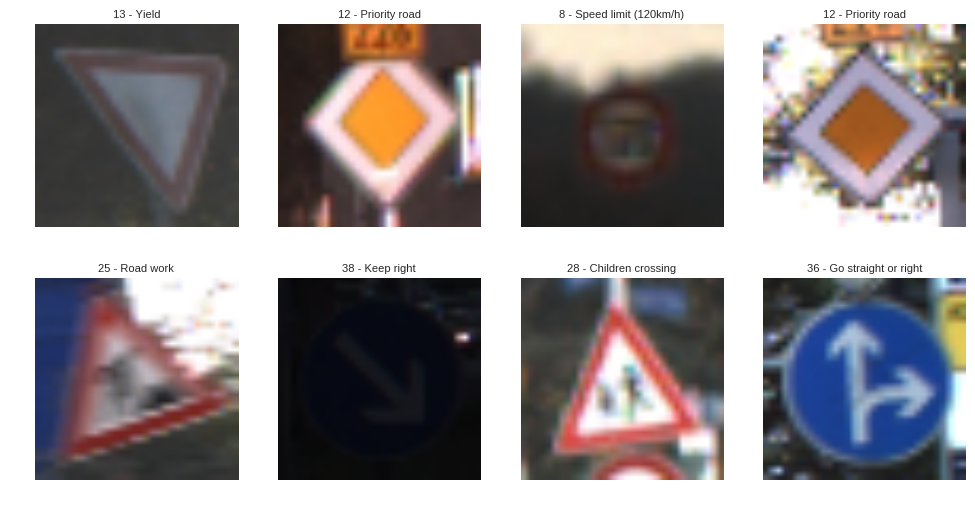

In [7]:
plot_signs(X_train, y_train)

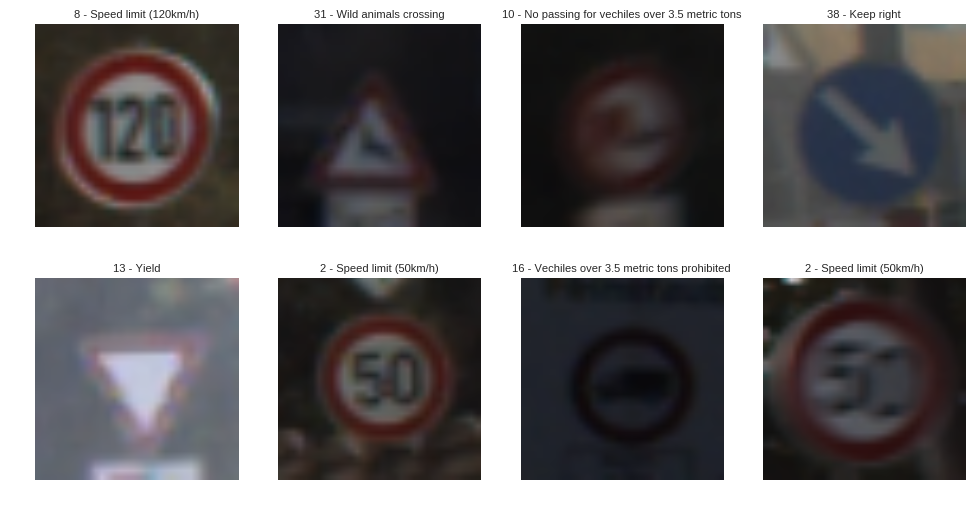

In [8]:
plot_signs(X_test, y_test)

### Class distribution

In [9]:
from collections import Counter
train_label_counter = Counter(y_train)

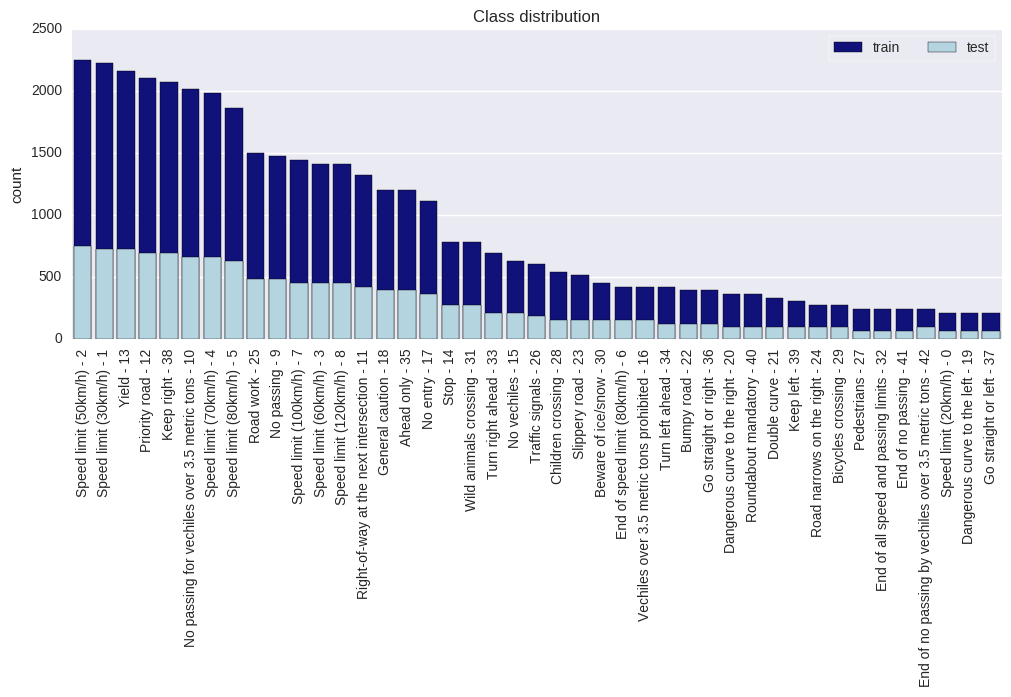

In [10]:
train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x=y_train, order=order, color='darkblue', ax=ax, label="train")

ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

The distribution of the train and test set are very similar which is good but the classes them selfe are quite imbalanced. It might be possible to generate additional data by transforming images. For example images with the label "Turn right ahead" could be mirrored to become "Turn left ahead".

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

In [11]:
from sklearn import preprocessing
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import cv2
from scipy import stats
import time
from datetime import datetime

#### Preprocessing

In [12]:
def normalize(images, newMax=1., newMin=0., oldMax=255, oldMin=0):
    return (images - oldMin) * ((newMax - newMin)/(oldMax - oldMin)) + newMin

In [13]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [14]:
#load jittered data
nb_jittered_sets = 4
path_jittered = 'data/train_jittered_%s.p'

if USE_JITTERED:
    i = 0
    for i in tnrange(nb_jittered_sets):
        with open(path_jittered % i, 'rb') as f:
            data = pickle.load(f)
            X_jittered, y_jittered = data['features'], data['labels']
            X_train = np.concatenate((X_train, X_jittered), axis=0)
            y_train = np.concatenate((y_train, y_jittered), axis=0)
        
print("Number of training features =", X_train.shape[0])
print("Number of training labels =", y_train.shape[0])


Number of training features = 196045
Number of training labels = 196045


In [15]:
#One hot encoding
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate((y_train, y_test), axis=0))

def one_hot_encoding(data, lb):
    encoded = np.array(lb.transform(data))
    encoded_cls = lb.inverse_transform(encoded)
    
    return encoded, encoded_cls

In [16]:
# Split train data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=SEED)

X_train, y_train = shuffle(X_train, y_train, random_state=SEED)
X_val, y_val = shuffle(X_val, y_val, random_state=SEED)

In [17]:
y_train, y_train_cls = one_hot_encoding(y_train, lb)
y_val, y_val_cls = one_hot_encoding(y_val, lb)
y_test, y_test_cls = one_hot_encoding(y_test, lb)

In [18]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [19]:
print("Number of training features =", X_train.shape[0])
print("Number of validation features =", X_val.shape[0])
print("Number of test features =", X_test.shape[0])

Number of training features = 137231
Number of validation features = 58814
Number of test features = 12630


#### Network

##### Helper

In [20]:
def _activation_summary(x):
    tensor_name = x.op.name
    tf.histogram_summary(tensor_name + '/activations', x)
    tf.scalar_summary(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

In [21]:
def create_weights(shape, mean=0.0, stddev=0.2, wd=None):
    weight = tf.Variable(tf.truncated_normal(shape, mean=mean, stddev=stddev, dtype=tf.float32), name='weights')
    
    if wd is not None:
        weight_decay = tf.mul(tf.nn.l2_loss(weight), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
        
    return weight


def create_biases(length, value=0.0):
    bias = tf.Variable(tf.fill([length], value), dtype=tf.float32, name='biases')
    return bias


def create_conv_layer(input,
                      num_filters,
                      filter_size=[1,1],
                      strides=[1, 1, 1, 1],
                      padding='SAME',
                      relu=True,
                      wd=None):

    num_input_channels = int(input.get_shape()[3]) 
    shape = [filter_size[0], filter_size[1], num_input_channels, num_filters]

    weights = create_weights(shape=shape, wd=wd)
    conv = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=strides,
                         padding=padding,
                         name='Convolution')

    
    biases = create_biases(length=num_filters)
    conv = tf.nn.bias_add(conv, biases)
    
    if relu == True:
        conv = tf.nn.relu(conv)
        
    _activation_summary(conv)
    
    return conv


def create_fc_layer(input,
                    num_inputs,
                    num_outputs,
                    relu=True,
                    wd=None):

    weights = create_weights(shape=[num_inputs, num_outputs], wd=wd)
    fc = tf.matmul(input, weights, name='Fully_Connected')
    
    biases = create_biases(length=num_outputs)
    fc = tf.nn.bias_add(fc, biases)
    
    if relu == True:
        fc = tf.nn.relu(fc)

    _activation_summary(fc)
        
    return fc


def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features], name='flatten')
    return layer_flat, num_features

In [22]:
def inference(images, keep_prop):
    tf.image_summary('images_raw', images)
        
    with tf.name_scope("color_space"):
        cs = create_conv_layer(images,
                          num_filters=10,
                          filter_size=[1,1],
                          strides=[1, 1, 1, 1],
                          padding='SAME',
                          relu=False,
                          wd=0.0)
        cs = create_conv_layer(cs,
                  num_filters=3,
                  filter_size=[1,1],
                  strides=[1, 1, 1, 1],
                  padding='SAME',
                  relu=False,
                  wd=0.0)
        tf.image_summary('images_color_space', cs)
    
    with tf.name_scope("conv1"):
        conv1 = create_conv_layer(cs,
                      num_filters=128,
                      filter_size=[5,5],
                      strides=[1, 1, 1, 1],
                      padding='SAME',
                      relu=True,
                      wd=0.0)
        
    pool1 = tf.nn.max_pool(conv1,
                           ksize=[1, 3, 3, 1], 
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='max_pool1')

    
    with tf.name_scope("conv2"):
        conv2 = create_conv_layer(pool1,
                      num_filters=256,
                      filter_size=[5,5],
                      strides=[1, 1, 1, 1],
                      padding='SAME',
                      relu=True,
                      wd=0.0)
        
    pool2 = tf.nn.max_pool(conv2,
                       ksize=[1, 3, 3, 1], 
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='max_pool2')
    
    with tf.name_scope("conv3"):
        conv3 = create_conv_layer(pool2,
                      num_filters=256,
                      filter_size=[3,3],
                      strides=[1, 1, 1, 1],
                      padding='SAME',
                      relu=True,
                      wd=0.0)
        
    pool3 = tf.nn.max_pool(conv3,
                       ksize=[1, 3, 3, 1], 
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='max_pool3')


    
    flatten, num_features = flatten_layer(pool3)
    
    dropout = tf.nn.dropout(flatten, keep_prob=keep_prop, name='Dropout', seed=SEED)
    
    with tf.name_scope("fc1"):
        fc1 = create_fc_layer(dropout,
                              num_inputs=num_features,
                              num_outputs=num_features,
                              relu=True,
                              wd=0.1)
        
    with tf.name_scope("softmax_linear"):
        softmax_linear = create_fc_layer(fc1,
                                         num_inputs=num_features,
                                         num_outputs=NUM_CLASSES,
                                         relu=False,
                                         wd=0.0)
    
    return softmax_linear

In [23]:
def get_loss(logits, labels, l2=True):
    with tf.name_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
          logits, labels, name='cross_entropy_per_example')

        cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
        tf.add_to_collection('losses', cross_entropy_mean)

        loss = tf.add_n(tf.get_collection('losses'), name='total_loss') if l2 else cross_entropy_mean
    
    return loss

In [24]:
def get_accuracy(logits, labels_cls):
    with tf.name_scope("evaluation"):
        pred = tf.nn.softmax(logits)
        pred_cls = tf.argmax(pred, dimension=1)
        correct_prediction = tf.equal(pred_cls, labels_cls)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

#### Train

In [25]:
def update_performance_plot(fig, ax, x_vals, y_vals):
    for y, line in zip(y_vals, ax.lines):
        line.set_xdata(x_vals)
        line.set_ydata(y)
        
    if len(x_vals) > 0 and x_vals[-1] > ax.get_xlim()[1] - 100:
        ax.set_xlim(0, ax.get_xlim()[1] + 1000)
    
    fig.canvas.draw()
    
def init_performance_plot(labels, colors):
    figsize = (12, 4)
    fig, ax = plt.subplots(figsize=figsize)
    num_ticks = 6
    ax.set_title('Performance')
    ax.set_ylim([0, 1.0])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('batches')
    
    [ax.plot([],[], color=c, label=l) for l, c in zip(labels, colors)]  
    ax.legend(loc=5)
    
    return (fig, ax)

In [26]:
def get_sample(x, y, sample_size):
    sample_size = min(x.shape[0], sample_size)
    i = np.random.choice(x.shape[0], sample_size)

    return x[i], y[i]

In [27]:
def calculate_for_sample(x, y, tf_op, sample_size=1000):
    sample_size = min(x.shape[0], sample_size)
    sample_features, sample_labels = get_sample(x, y, sample_size)

    feed_dict = {features: sample_features, labels: sample_labels, keep_prop:1}
    return session.run(tf_op, feed_dict=feed_dict)

In [28]:
def update_metrics(accuracy, loss, sample_size=1000):
    global valid_loss_batch
    global valid_acc_batch
    global train_loss_batch
    global train_acc_batch
    
    val_loss, val_acc = calculate_for_sample(X_val,
                                             y_val,                      
                                             [loss, accuracy],
                                             sample_size=sample_size)

    valid_loss_batch.append(val_loss)
    valid_acc_batch.append(val_acc)


    train_loss, train_acc = calculate_for_sample(X_train,
                                                 y_train,
                                                 [loss, accuracy],
                                                 sample_size=sample_size)              
    train_loss_batch.append(train_loss)
    train_acc_batch.append(train_acc)

<IPython.core.display.Javascript object>


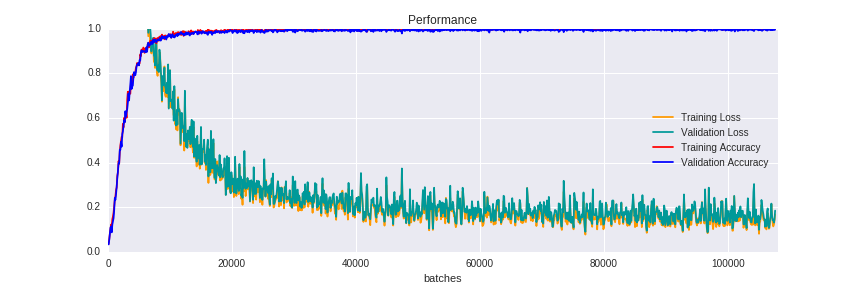

In [29]:
%matplotlib notebook
valid_loss_batch = []
valid_acc_batch = []
train_loss_batch = []
train_acc_batch = []
batches = []
predictions = []
batch_count = int(math.ceil(len(X_train)/BATCH_SIZE))
max_steps = EPOCHS * len(X_train)
fig, ax = init_performance_plot(['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'],
                               ['#FF9900', '#009999', '#FF0000', '#0000FF'])


tf.reset_default_graph()
with tf.Graph().as_default():
    with tf.name_scope("variables"):
        features = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name='features')
        labels = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='labels')
        labels_cls = tf.argmax(labels, dimension=1, name='labels_cls')
        keep_prop = tf.placeholder(dtype=tf.float32, name='keep_prop')

                                   
    logits = inference(features, keep_prop)
    loss = get_loss(logits, labels)
    accuracy = get_accuracy(logits, labels_cls)
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss) 

    saver = tf.train.Saver(tf.all_variables())
    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()                                  
       

    # Start running operations on the Graph.
    with tf.Session() as session:
        session.run(init)
        summary_writer = tf.train.SummaryWriter(TRAIN_DIR, session.graph)
                                   
        for epoch_i in range(EPOCHS):
            batches_pbar = tnrange(batch_count,
                                   desc='Epoch %s/%s' % (epoch_i+1, EPOCHS),
                                   unit=' batches ',
                                   leave=False,
                                   smoothing=0.3)

            for batch_i in batches_pbar:
                step = epoch_i * BATCH_SIZE + batch_i
                batch_start = batch_i*BATCH_SIZE
                batch_features = X_train[batch_start:batch_start + BATCH_SIZE]
                batch_labels = y_train[batch_start:batch_start + BATCH_SIZE]

                feed_dict={features: batch_features,
                           labels: batch_labels,
                           keep_prop:KEEP_PROP}
                
                _ = session.run(optimizer, feed_dict=feed_dict)


                #Log and write summary
                if step % 100 == 0:                                  
                    previous_batch = batches[-1] if batches else 0
                    batches.append(previous_batch + 100)

                    update_metrics(accuracy, loss)
                    update_performance_plot(fig, ax, batches, [train_loss_batch,
                                                               valid_loss_batch,
                                                               train_acc_batch,
                                                               valid_acc_batch])


                    summary_str = session.run(summary_op, feed_dict=feed_dict)
                    summary_writer.add_summary(summary_str, step)
                    
                # Save the model checkpoint periodically.
                if step % 1000 == 0 or (step + 1) == max_steps:
                    checkpoint_path = os.path.join(TRAIN_DIR, 'model.ckpt')
                    saver.save(session, checkpoint_path, global_step=step)
                                   
                            
%matplotlib inline

In [38]:
test_epochs = 10
test_batch_acc = []
retrain = False
batch_count = int(math.ceil(len(X_test)/BATCH_SIZE))

with tf.Graph().as_default():
    with tf.name_scope("variables"):
        features = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name='features')
        labels = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='labels')
        labels_cls = tf.argmax(labels, dimension=1, name='labels_cls')
        keep_prop = tf.constant(1., name='keep_prop')

                                   
    logits = inference(features, keep_prop)
    loss = get_loss(logits, labels)
    accuracy = get_accuracy(logits, labels_cls)
    with tf.Session() as session:
  
        saver = tf.train.Saver(tf.all_variables())
        ckpt = tf.train.latest_checkpoint(TRAIN_DIR)
        saver.restore(session, ckpt)

        pred_bar = tqdm_notebook(range(batch_count), desc='Making predictions', unit='batches')

        for batch_i in pred_bar:
            batch_start = batch_i*BATCH_SIZE
            batch_end = min(batch_i + BATCH_SIZE, y_test.shape[0])
            batch_features = X_test[batch_start:batch_start + BATCH_SIZE]
            batch_labels = y_test[batch_start:batch_start + BATCH_SIZE]
            feed_dict={features: batch_features, labels: batch_labels}
            test_batch_acc.append(session.run(accuracy, feed_dict=feed_dict))

In [39]:
print('Test Accuracy: %s' % np.mean(test_batch_acc))

Test Accuracy: 0.976249


#### Execution

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [32]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [33]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [34]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [35]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [36]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [37]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.